In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path
from pymatgen.core import Structure, Composition, Element

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
qc_ac_te_mp_dataset = pd.read_pickle('common_data/qc_ac_te_mp_rebuild_T=290K_20250202.pd.xz')

qc_ac_te_mp_dataset.head(3)
qc_ac_te_mp_dataset.shape

,formula,hypermaterial_type,temperature,composition,elements,Thermal conductivity,Seebeck coefficient,Carrier concentration,Electrical conductivity,Thermopower,...,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Magnetic susceptibility,Specific heat capacity,Hall coefficient,Electronic contribution,Electronic thermal conductivity
id,,,,,,,,,,,,,,,,,,,,,
starry_0,(ErAs)0.003InGaAs,others,290,"(Er, As, In, Ga)","(Er, As, In, Ga)",3.2670491071158483,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,Al61.5Cu26.5Fe12,IQC,290,"(Al, Cu, Fe)","(Al, Cu, Fe)",1.4258964578008275,-1.1863527516689362e-05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,Bi2Te2.4Se0.6,others,290,"(Bi, Te, Se)","(Bi, Te, Se)",NaN,NaN,-5.436073908332581e+24,1063.8779641515926,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(41017, 27)

---

In [79]:
starry_props = [
    "Thermal conductivity",
    "Carrier concentration",
    "Electrical conductivity",
    "Thermopower",
    "Electrical resistivity",
    "Power factor",
    "Seebeck coefficient",
    "Lattice thermal conductivity",
    "ZT",
    "Hall mobility",
    "Electronic contribution",
    "Electronic thermal conductivity",
]

ac_qc_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Magnetic susceptibility",
    "Specific heat capacity",
    "Hall coefficient",
    "ZT",
    "Power factor",
]

mp_props = [
    "Band gap",
    "Density",
    "Efermi",
    "Final energy per atom",
    "Formation energy per atom",
    "Total magnetization",
    "Volume",  
]

ac_qc_starry_shared_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Power factor",
    "ZT",
]

ac_qc_starry_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Magnetic susceptibility",
    "Specific heat capacity",
    "Hall coefficient",
    "ZT",
    "Power factor",
    "Carrier concentration",
    "Electrical conductivity",
    "Thermopower",
    "Lattice thermal conductivity",
    "Hall mobility",
    "Electronic contribution",
    "Electronic thermal conductivity",
]

all_props = ac_qc_starry_props + mp_props

qc_ac_te_mp_props = qc_ac_te_mp_dataset[all_props]

In [80]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

qc_ac_te_mp_props = qt.fit_transform(qc_ac_te_mp_props)

qc_ac_te_mp_props.shape
qc_ac_te_mp_props.head(3)

(41017, 22)

,Seebeck coefficient,Thermal conductivity,Electrical resistivity,Magnetic susceptibility,Specific heat capacity,Hall coefficient,ZT,Power factor,Carrier concentration,Electrical conductivity,...,Hall mobility,Electronic contribution,Electronic thermal conductivity,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume
id,,,,,,,,,,,,,,,,,,,,,
starry_0,NaN,0.043194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,-0.389599,-0.816999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.963278,-1.095324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----

In [51]:
from xenonpy.descriptor import Compositions
from sklearn.preprocessing import MinMaxScaler, StandardScaler

featurizers = ['WeightedAverage', 'WeightedVariance', 'MaxPooling', 'MinPooling']
comp_calc = Compositions(featurizers=featurizers, n_jobs=20)  # use specific featurizers

In [81]:
all_comp_desc = comp_calc.fit_transform(qc_ac_te_mp_dataset).dropna()
qc_ac_te_mp_props = qc_ac_te_mp_props.loc[all_comp_desc.index]

s_scaler = StandardScaler().set_output(transform="pandas")
all_comp_std_desc = s_scaler.fit_transform(all_comp_desc)

all_comp_desc.shape
all_comp_desc.head(3)
all_comp_std_desc.head(3)

(40975, 232)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
id,,,,,,,,,,,,,,,,,,,,,
starry_0,37.692282,148.686294,236.696274,13.537758,86.556599,1968.408516,61.147068,454.500998,127.719228,129.027944,...,2.0,4.0,0.168,15.00,185.0,188.0,236.0,339.1,1215.0,4.31
qa_1,18.800000,136.985000,231.610000,8.883500,40.134736,2800.460000,104.240000,455.520000,126.435000,121.090000,...,1.0,3.0,0.385,80.00,184.0,225.0,223.0,291.2,3570.0,6.20
starry_2,62.240000,161.600000,243.040000,20.340000,154.316680,1474.412000,44.596000,459.240000,139.840000,139.600000,...,2.0,4.0,0.124,0.52,190.0,182.0,229.0,420.5,1790.0,3.77


,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
id,,,,,,,,,,,,,,,,,,,,,
starry_0,0.331550,-0.104419,0.554617,-0.482796,0.267949,0.057978,-0.439582,-0.768862,0.026679,0.447008,...,0.965040,0.907911,-0.448959,0.189519,0.408410,0.015540,1.014633,0.833988,-0.328497,0.297629
qa_1,-0.832386,-0.862016,0.328896,-1.407353,-0.862436,0.831724,0.397768,-0.766968,-0.022650,0.101002,...,-0.781383,0.039343,1.026641,3.193129,0.368905,1.004690,0.521067,-0.488995,1.501360,0.982271
starry_2,1.843912,0.731675,0.836143,0.868452,1.917926,-0.401403,-0.761190,-0.760056,0.492250,0.907831,...,0.965040,0.907911,-0.748159,-0.479593,0.605932,-0.144863,0.748867,3.082231,0.118283,0.102017


## NN model

In [105]:
used_props = qc_ac_te_mp_props[ac_qc_starry_props].dropna(how='all')
uesd_desc = all_comp_desc.loc[used_props.index]

In [200]:
%run multi_task.py
%run plot_utils.py

Using device: cuda
Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)

Model:
CompoundPropertyPredictor(
  (shard_block): LinearBlock(
    (layers): Sequential(
      (0): Sequential(
        (0): LinearLayer(
          (layer): Linear(in_features=232, out_features=128, bias=True)
          (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): ResidualBlock(
          (layers): Sequential(
            (0): LinearLayer(
              (layer): Linear(in_features=128, out_features=128, bias=True)
              (normal): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activation): LeakyReLU(negative_slope=0.1)
            )
            (1): LinearLayer(

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,r2,mae,rmse,property
0,0.411831,0.516167,0.805947,Seebeck coefficient
1,0.389702,0.540969,0.822068,Thermal conductivity
2,0.461743,0.480409,0.775263,Electrical resistivity
3,-1.488128,1.382298,2.597847,Magnetic susceptibility
4,NaN,10.424036,10.424036,Specific heat capacity
5,0.000000,0.031180,0.033815,Hall coefficient


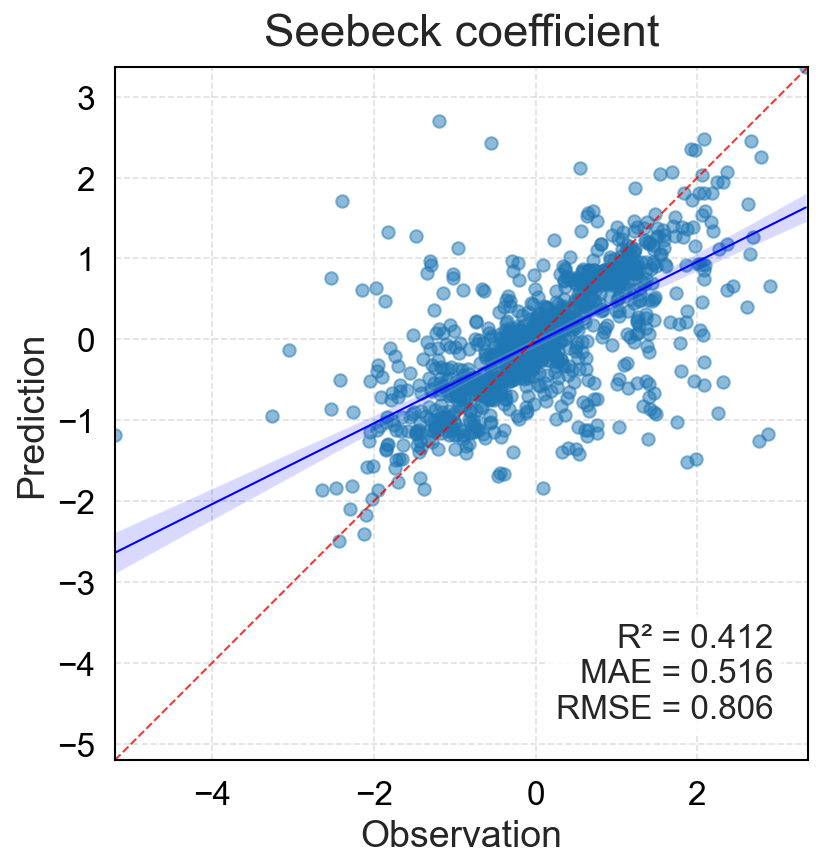

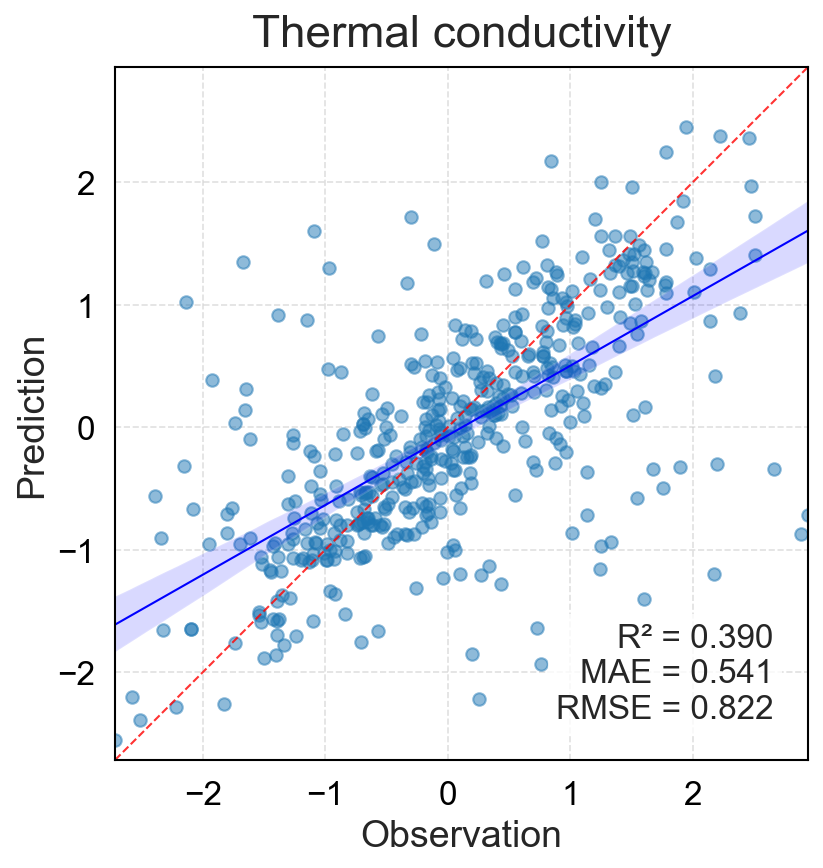

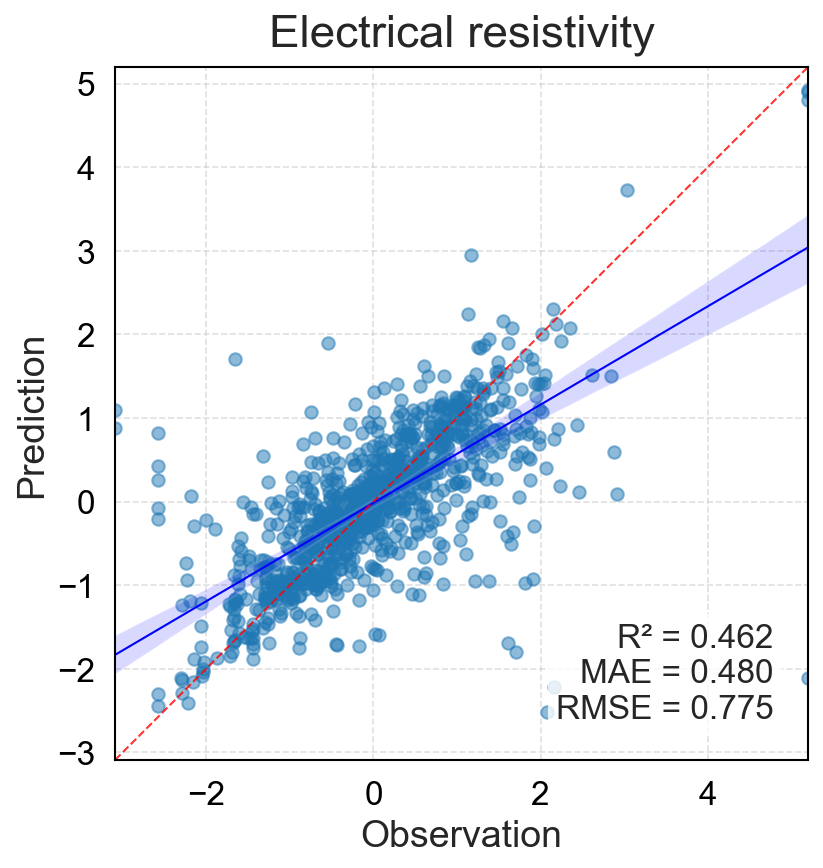

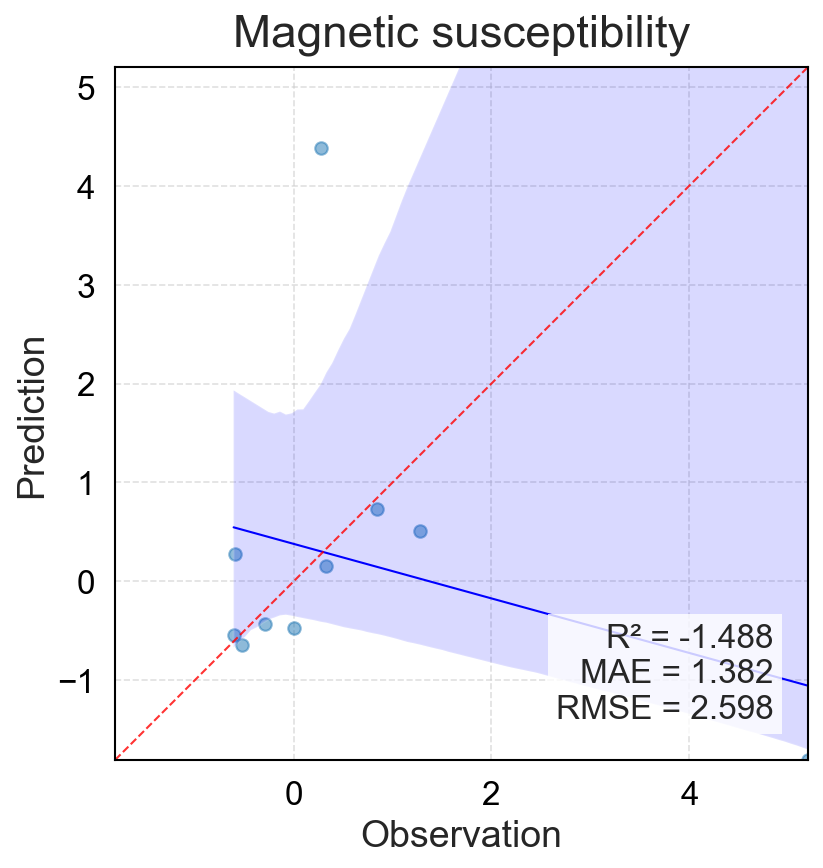

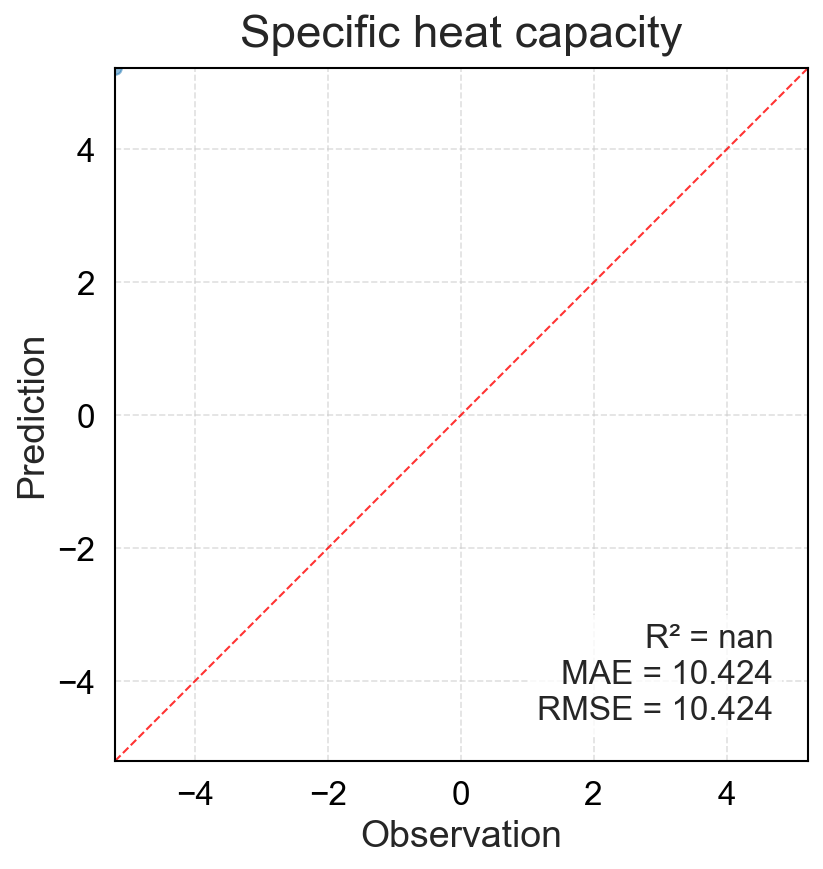

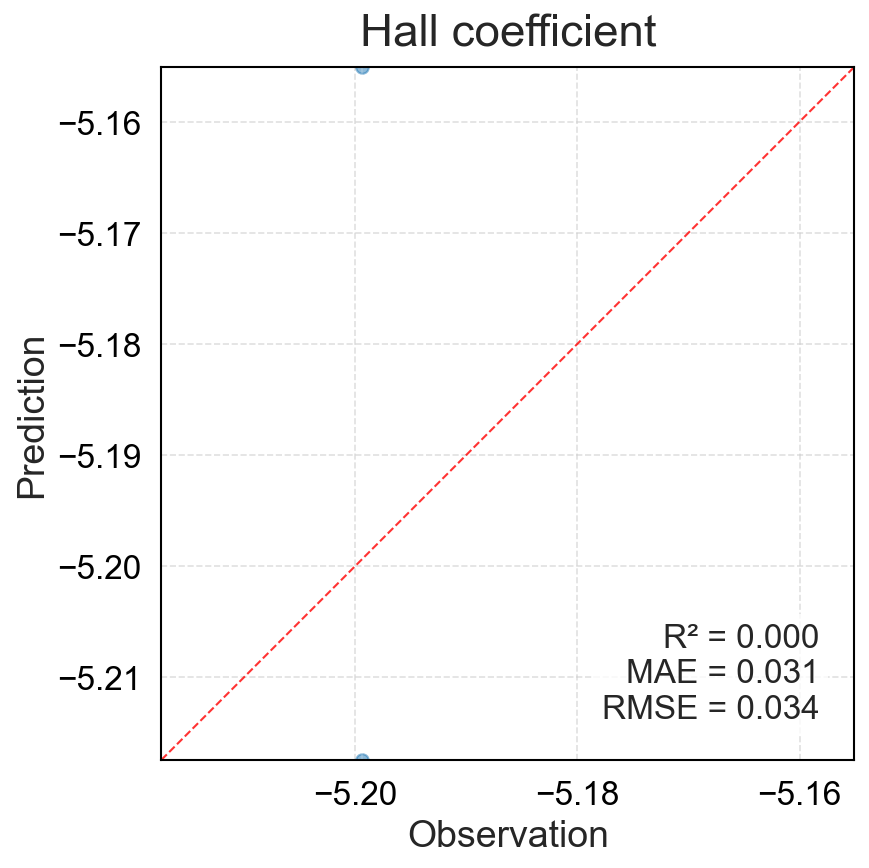

In [211]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")

train_data_idx, test_data_idx = train_test_split(uesd_desc.index, test_size=0.2, random_state=0, stratify=qc_ac_te_mp_dataset.loc[used_props.index].hypermaterial_type)

# Prepare datasets
known_attributes = {
    'ZT': 1.,,
    'Seebeck coefficient': 1.,
    'Thermal conductivity': 1.,
    'Electrical resistivity': 1.,
    'Magnetic susceptibility': 1.,
    'Specific heat capacity': 1.,
    'Hall coefficient': 1.,
    'Power factor': 1.,
    'Carrier concentration': 1.,
    'Electrical conductivity': 1.,
    'Thermopower': 1.,
    'Lattice thermal conductivity': 1.,
    'Hall mobility': 1.,
    'Electronic contribution': 1.,
    'Electronic thermal conductivity': 1.,
    'Band gap': 1.,
    'Density': 1.,
    'Efermi': 1.,
    'Final energy per atom': 1.,
    'Formation energy per atom': 1.,
    'Total magnetization': 1.,
    'Volume': 1.
}

train_dataset = CompoundDataset(
    descriptor=uesd_desc.loc[train_data_idx], property=used_props.loc[train_data_idx], attributes=ac_qc_starry_props, **known_attributes
)
test_dataset = CompoundDataset(
    descriptor=uesd_desc.loc[test_data_idx], property=used_props.loc[test_data_idx], attributes=ac_qc_starry_props
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Initialize model
shared_block_dims = [uesd_desc.shape[1], 128, 64, 32]
task_block_dims = [32, 16, 1]
model = CompoundPropertyPredictor(
    shared_block_dims=shared_block_dims,
    task_block_dims=task_block_dims,
    n_tasks=15,
    norm_shared=True,
    norm_tasks=True,
    residual_shared=True,
    residual_tasks=True,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train and evaluate
avg_test_loss, all_preds, all_targets, all_masks = train_and_evaluate(
    model, train_loader, test_loader, optimizer, device, num_epochs=500
)

plot_predictions(all_preds, all_targets, all_masks, savefig='images/multi_tasks_20250202/', suffix='all_qc_ac_te_data', return_stat=True)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,r2,mae,rmse,property
0,0.323127,0.587736,0.864587,Seebeck coefficient
1,0.389243,0.582983,0.822376,Thermal conductivity
2,0.434651,0.531367,0.794534,Electrical resistivity
3,-2.512744,1.954948,3.086743,Magnetic susceptibility
4,NaN,10.567348,10.567348,Specific heat capacity
5,0.000000,0.118831,0.118847,Hall coefficient


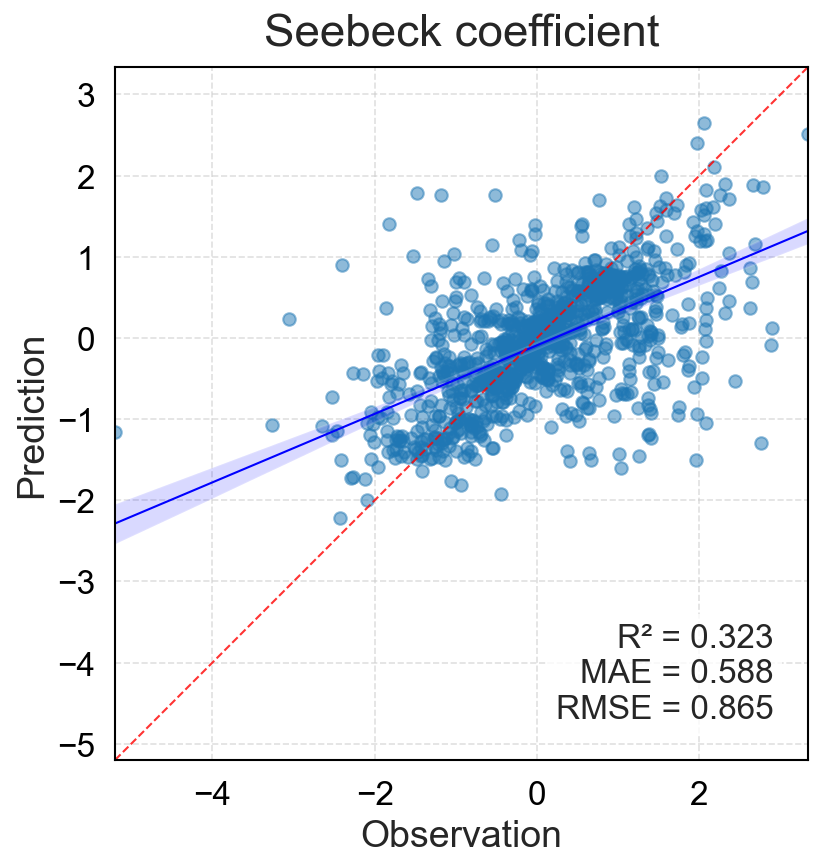

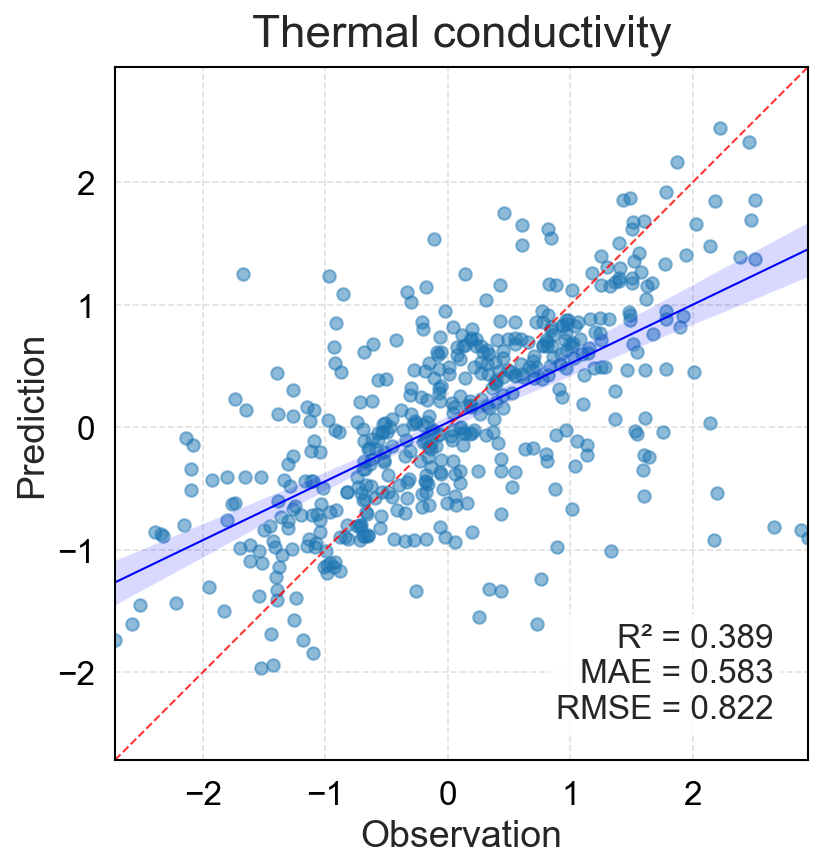

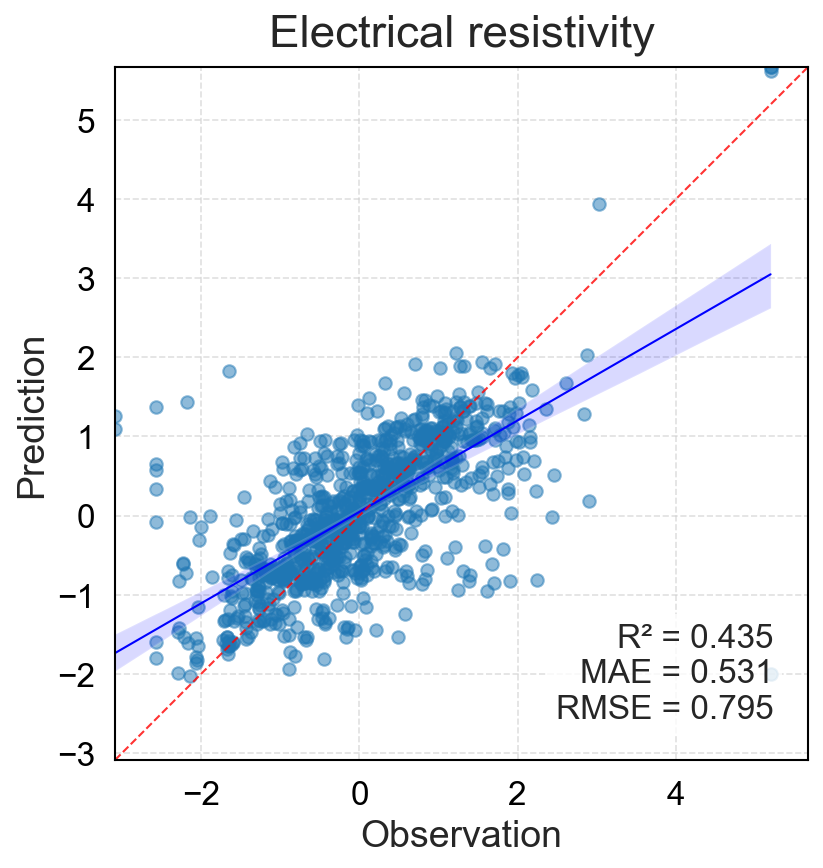

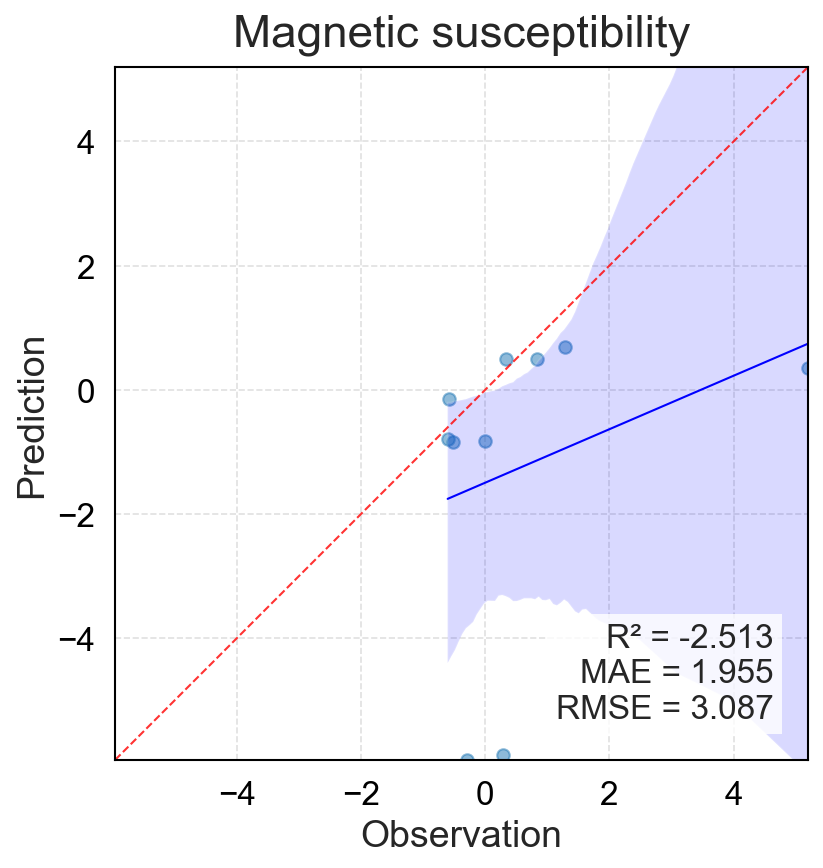

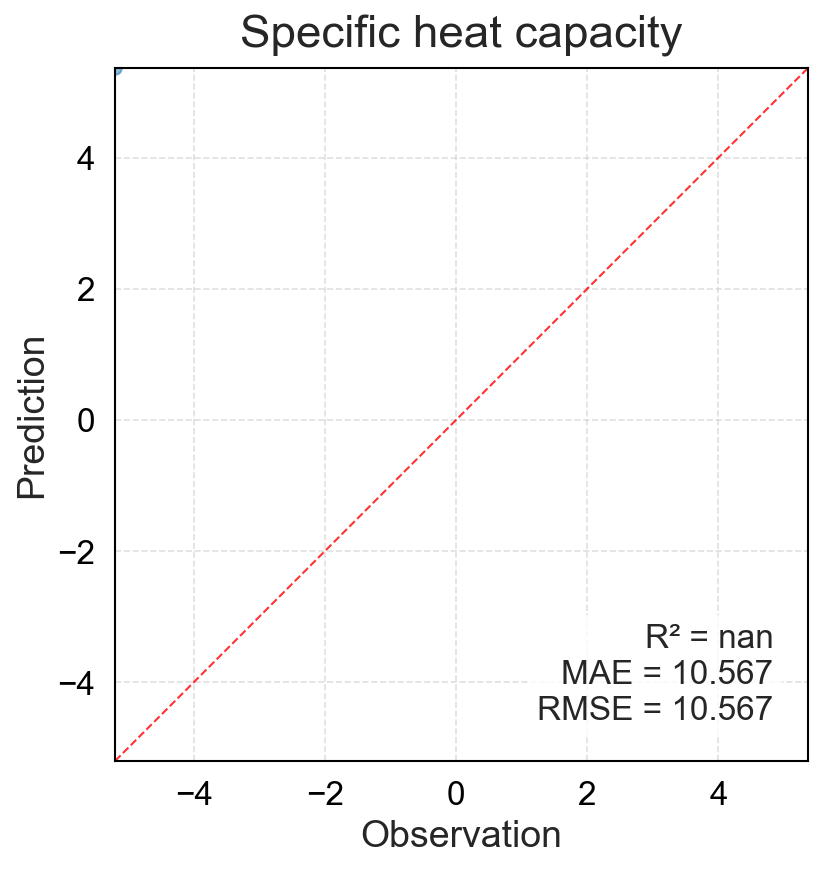

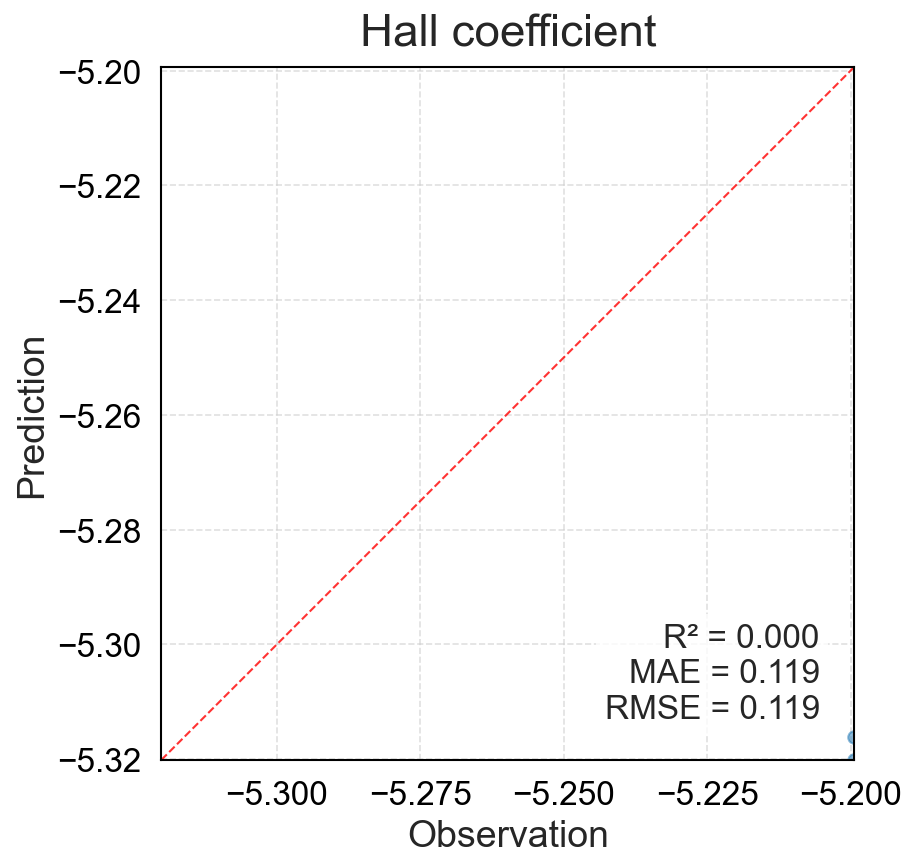

In [208]:
plot_predictions(all_preds, all_targets, all_masks, savefig='images/multi_tasks/', suffix='all_qc_ac_te_data', return_stat=True)

In [103]:
pd.concat([used_props, used_props], axis=1).to_pickle('common_data/qc_ac_te_multi_task_train_data.pd.xz')

---

In [ ]:
%run multi_task.py
%run plot_utils.py

In [22]:
from typing import Optional, Dict, List, Tuple
import torch
import pandas as pd
from pathlib import Path
# from multi_task import scaling_laws_test, CompoundDataset

def test_all_properties(
    descriptor_df: pd.DataFrame,
    property_df: pd.DataFrame,
    device: str = 'cuda'
) -> Dict[str, Dict[str, Tuple[List[float], List[float], List[float]]]]:
    """
    Test scaling laws for all properties in both vary_target and vary_others modes.
    
    Args:
        descriptor_df: DataFrame containing input features
        property_df: DataFrame containing property values
        device: Device to run the model on ('cpu' or 'cuda')
    
    Returns:
        Dict with structure:
        {
            property_name: {
                'vary_target': (test_losses, test_losses_std, fractions),
                'vary_others': (test_losses, test_losses_std, fractions)
            }
        }
        where:
        - test_losses: List of mean test losses for each fraction
        - test_losses_std: List of standard deviations of test losses
        - fractions: List of data fractions used
    """
    results: Dict[str, Dict[str, Tuple[List[float], List[float], List[float]]]] = {}
    
    # Create results directory
    results_dir = Path('images/multi_tasks/scaling_laws')
    results_dir.mkdir(parents=True, exist_ok=True)
    
    # Test each property
    for property_name in CompoundDataset.ATTRIBUTES:
        if property_name != 'seebeck_coefficient':
            continue
        results[property_name] = {}
        print(f"\n{'='*80}")
        print(f"Testing scaling laws for {property_name}")
        print(f"{'='*80}")
        
        # Test vary_target mode
        print(f"\nMode: vary_target (varying {property_name} data while fixing others)")
        results[property_name]['vary_target'] = scaling_laws_test(
            descriptor=descriptor_df,
            property_data=property_df,
            target_property=property_name,
            mode='vary_target',
            device=device
        )
        
        # # Test vary_others mode
        # print(f"\nMode: vary_others (fixing {property_name} while varying others)")
        # results[property_name]['vary_others'] = scaling_laws_test(
        #     descriptor=descriptor_df,
        #     property_data=property_df,
        #     target_property=property_name,
        #     mode='vary_others',
        #     device=device
        # )

    return results

In [23]:
if __name__ == '__main__':
    # Example usage
    
    # Check for CUDA availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Run tests
    scaling_results = test_all_properties(used_props, used_props, device=device)

Epoch [91/100], Training Loss: 4.2651

Test Losses by Attribute:
electrical_resistivity: 9.7488
thermal_conductivity: 0.8889
seebeck_coefficient: 2.3087
power_factor: 3.9028
zt: 3.6565
hall_coefficient: 10.2821
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
Epoch [1/100], Training Loss: 17.2831
Epoch [11/100], Training Loss: 9.2160
Epoch [21/100], Training Loss: 7.2978
Epoch [31/100], Training Loss: 6.1254
Epoch [41/100], Training Loss: 5.4639
Epoch [51/100], Training Loss: 4.9149
Epoch [61/100], Training Loss: 4.7575
Epoch [71/100], Training Loss: 4.5109
Epoch [81/100], Training Loss: 4.1791
Epoch [91/100], Training Loss: 3.9139

Test Losses by Attribute:
electrical_resistivity: 11.5605
thermal_conductivity: 1.0197
seebeck_coefficient: 2.0764
power_factor: 3.9222
zt: 3.6494
hall_coefficient: 6.9492

Testing with 

In [ ]:
import joblib

with open('scaling_results.pkl.z', 'wb') as fo:  
   joblib.dump(scaling_results, fo)